In [1]:
import numpy as np
import random  # for the random wirings
import time # to compare the algorithm timings
import timeit

> See the attached PDF for the meaning of the notations.

Here $W$ is a matrix whose columns are wirings:

In [2]:
nb_columns = 1

def random_wiring():
    #return np.array([[random.random() for _ in range(32)] for _ in range(nb_columns)]).T
    return np.random.rand(32, nb_columns)

print(random_wiring().shape)

W_BS09 = [0, 0, 1, 1,              # f_1(x, a_2) = x
          0, 0, 1, 1,              # g_1(y, b_2) = y
          0, 0, 0, 1,              # f_2(x, a_1) = a_1*x
          0, 0, 0, 1,              # g_2(y, b_1) = b_1*y
          0, 1, 1, 0, 0, 1, 1, 0,  # f_3(x, a_1, a_2) = a_1 + a_2 mod 2
          0, 1, 1, 0, 0, 1, 1, 0   # g_3(y, b_1, b_2) = b_1 + b_2 mod 2
         ]
W_BS09 = np.tensordot(np.ones(nb_columns), W_BS09, axes=0).T
print(W_BS09.shape)

(32, 1)
(32, 1)


# I. Vectorialization

## 1.1. Definition of h

In [3]:
"""def matrix_to_tensor(Matrix):
    Tensor = np.zeros((2,2,2,2))
    for i in range(4):
        for j in range(4):
            b = j%2
            a = (j-b)//2
            y = i%2
            x = (i-y)//2
            Tensor[a,b,x,y] = Matrix[i,j]
    return Tensor"""

def matrix_to_tensor(Matrix):
    return np.transpose(np.reshape(Matrix, (2,2,2,2)), (2,3,0,1))

In [4]:
"""CHSH = np.array([
    [0.25, 0, 0, 0.25],
    [0.25, 0, 0, 0.25],
    [0.25, 0, 0, 0.25],
    [0, 0.25, 0.25, 0]
])"""

CHSH = np.zeros((4,4))

for a in range(2):
    for b in range(2):
        for x in range(2):
            for y in range(2):
                if (a+b)%2 == x*y:
                    CHSH[2*x+y, 2*a+b]=0.25
                    
print(CHSH)

[[0.25 0.   0.   0.25]
 [0.25 0.   0.   0.25]
 [0.25 0.   0.   0.25]
 [0.   0.25 0.25 0.  ]]


In [5]:
CHSH_flat = matrix_to_tensor( CHSH ).flatten()
#CHSH_flat = np.reshape(CHSH, (16))

def h_flat(R):
    R = np.reshape(R, (16, -1))
    return np.dot( CHSH_flat, R )  # scalar product of CHSH and each column of R

In [6]:
PR = np.zeros((4,4))
for a in range(2):
    for b in range(2):
        for x in range(2):
            for y in range(2):
                if (a+b)%2 == x*y:
                    PR[2*x+y, 2*a+b]=0.5
                

SR = np.zeros((4,4))
for a in range(2):
    for b in range(2):
        for x in range(2):
            for y in range(2):
                if a==b:
                    SR[2*x+y, 2*a+b]=0.5

In [7]:
h_flat(matrix_to_tensor(PR))

array([1.])

In [8]:
h_flat(matrix_to_tensor(SR))

array([0.75])

## 1.2. Computation of A(W)

In [9]:
# A1 is a 2x4x4x32-tensor
A1 = np.zeros( (2, 4, 4, 32) )

for x in range(2):
    for j in range(4):
        
        sign = 1
        if j >= 2:
            sign=-1
            
        A1[x, 0, j, 0] = sign*(x-1)
        A1[x, 1, j, 0] = sign*(x-1)
        A1[x, 2, j, 1] = sign*(x-1)
        A1[x, 3, j, 1] = sign*(x-1)
        
        A1[x, 0, j, 2] = sign*(-x)
        A1[x, 1, j, 2] = sign*(-x)
        A1[x, 2, j, 3] = sign*(-x)
        A1[x, 3, j, 3] = sign*(-x)

#print(A1)

In [10]:
# A2 is a 2x4x4xnb_columns-tensor
A2 = np.zeros( (2, 4, 4, nb_columns) )

for x in range(2):
    for i in range(4):
        for k in range(4):
            for alpha in range(nb_columns):
                if k<=1:
                    A2[x, i, k]=1

#print(A2)

In [11]:
"""W_BS09 = [0, 0, 1, 1,              # f_1(x, a_2) = x
          0, 0, 1, 1,              # g_1(y, b_2) = y
          0, 0, 0, 1,              # f_2(x, a_1) = a_1*x
          0, 0, 0, 1,              # g_2(y, b_1) = b_1*y
          0, 1, 1, 0, 0, 1, 1, 0,  # f_3(x, a_1, a_2) = a_1 + a_2 mod 2
          0, 1, 1, 0, 0, 1, 1, 0   # g_3(y, b_1, b_2) = b_1 + b_2 mod 2
         ]"""

(np.tensordot(A1, random_wiring(), axes=([3, 0])) + A2).shape

(2, 4, 4, 1)

-> This is indeed the wanted result

In [12]:
# A3 is a 2x4x4x32-tensor
A3 = np.zeros( (2, 4, 4, 32) )

for y in range(2):
    for j in range(4):
        
        sign = 1
        if j==1 or j==3:
            sign=-1
            
        A3[y, 0, j, 0 +4] = sign*(y-1)
        A3[y, 2, j, 0 +4] = sign*(y-1)
        A3[y, 1, j, 1 +4] = sign*(y-1)
        A3[y, 3, j, 1 +4] = sign*(y-1)
        
        A3[y, 0, j, 2 +4] = sign*(-y)
        A3[y, 2, j, 2 +4] = sign*(-y)
        A3[y, 1, j, 3 +4] = sign*(-y)
        A3[y, 3, j, 3 +4] = sign*(-y)
        
#print(A3)

In [13]:
# A4 is a 2x4x4xnb_columns-tensor
A4 = np.zeros( (2, 4, 4, nb_columns) )

for y in range(2):
    for i in range(4):
        for k in range(4):
            for alpha in range(nb_columns):
                if k==0 or k==2:
                    A4[y, i, k]=1
                
#print(A4)

In [14]:
(np.tensordot(A3, random_wiring(), axes=([3, 0])) + A4).shape

(2, 4, 4, 1)

-> We indeed obtain the wanted result.

We obtain $A(W)$:

In [15]:
def A(W):  # W is a vector with 32 entries
    T1 = np.tensordot(A1, W, axes=([3, 0])) + A2
    T2 = np.tensordot(np.ones((2)), T1, axes=0)
    T3 = np.transpose(T2, (1,0,2,3,4))
    S1 = np.tensordot(A3, W, axes=([3, 0])) + A4
    S2 = np.tensordot(np.ones((2)), S1, axes=0)
    return np.transpose(T3 * S2, (0,1,4,2,3))

A(random_wiring()).shape
    

(2, 2, 1, 4, 4)

-> This is the wanted result.

## 1.3. Definition of B(W)

In [16]:
# B1 is a 2x4x4x32-tensor
B1 = np.zeros( (2, 4, 4, 32) )

for x in range(2):
    for l in range(4):
        
        sign = 1
        if l>=2:
            sign=-1
            
        B1[x, 0, l, 0 +8] = sign * (x-1)
        B1[x, 1, l, 0 +8] = sign * (x-1)
        B1[x, 2, l, 1 +8] = sign * (x-1)
        B1[x, 3, l, 1 +8] = sign * (x-1)
        
        B1[x, 0, l, 2 +8] = sign * (-x)
        B1[x, 1, l, 2 +8] = sign * (-x)
        B1[x, 2, l, 3 +8] = sign * (-x)
        B1[x, 3, l, 3 +8] = sign * (-x)

#print(B1)

In [17]:
# B2 is equal to A2
B2 = A2

#print(B2)

In [18]:
# B3 is a 2x4x4x32-tensor
B3 = np.zeros( (2, 4, 4, 32) )

for y in range(2):
    for l in range(4):
        
        sign=1
        if l==1 or l==3:
            sign=-1
        
        B3[y, 0, l, 0 +12] = sign * (y-1)
        B3[y, 2, l, 0 +12] = sign * (y-1)
        B3[y, 1, l, 1 +12] = sign * (y-1)
        B3[y, 3, l, 1 +12] = sign * (y-1)
        
        B3[y, 0, l, 2 +12] = sign * (-y)
        B3[y, 2, l, 2 +12] = sign * (-y)
        B3[y, 1, l, 3 +12] = sign * (-y)
        B3[y, 3, l, 3 +12] = sign * (-y)

#print(B3)

In [19]:
# B4 is equal to A4
B4 = A4

#print(B4)

In [20]:
def B(W):   # W is a vector with 32 entries
    T1 = np.tensordot(B1, W, axes=([3, 0])) + B2
    T2 = np.tensordot(np.ones((2)), T1, axes=0)
    T3 = np.transpose(T2, (1,0,2,3,4))
    S1 = np.tensordot(B3, W, axes=([3, 0])) + B4
    S2 = np.tensordot(np.ones((2)), S1, axes=0)
    return np.transpose(T3 * S2, (0,1,4,2,3))

B(random_wiring()).shape


(2, 2, 1, 4, 4)

-> This is the wanted result.

## 1.4. Definition of C(W)

In [21]:
# C1 is a 2x2x4x4x32-tensor
C1 = np.zeros( (2, 2, 4, 4, 32) )

for a in range(2):
    for x in range(2):
        for j in range(4):
            if j<=1:
                C1[a, x, 0, j, 0 +16] = -(1-x) * (-1)**a
                C1[a, x, 1, j, 0 +16] = -(1-x) * (-1)**a
                C1[a, x, 2, j, 1 +16] = -(1-x) * (-1)**a
                C1[a, x, 3, j, 1 +16] = -(1-x) * (-1)**a
                
                C1[a, x, 0, j, 4 +16] = -(x) * (-1)**a
                C1[a, x, 1, j, 4 +16] = -(x) * (-1)**a
                C1[a, x, 2, j, 5 +16] = -(x) * (-1)**a
                C1[a, x, 3, j, 5 +16] = -(x) * (-1)**a
            
            if j>=2:
                C1[a, x, 0, j, 0 +18] = -(1-x) * (-1)**a
                C1[a, x, 1, j, 0 +18] = -(1-x) * (-1)**a
                C1[a, x, 2, j, 1 +18] = -(1-x) * (-1)**a
                C1[a, x, 3, j, 1 +18] = -(1-x) * (-1)**a
                
                C1[a, x, 0, j, 4 +18] = -(x) * (-1)**a
                C1[a, x, 1, j, 4 +18] = -(x) * (-1)**a
                C1[a, x, 2, j, 5 +18] = -(x) * (-1)**a
                C1[a, x, 3, j, 5 +18] = -(x) * (-1)**a
                

#print(C1)

In [22]:
np.tensordot(C1, random_wiring(), axes=([4, 0])).shape

(2, 2, 4, 4, 1)

-> This is indeed the expected result.

In [23]:
# C2 is a 2x2x4x4xnb_columns-tensor
C2 = np.zeros( (2, 2, 4, 4, nb_columns) )

for x in range(2):
    for i in range(4):
        for j in range(4):
            for alpha in range(nb_columns):
                C2[0, x, i, j]=1
            
print(C2.shape)

(2, 2, 4, 4, 1)


---
#### Kronecker product:

In [24]:
v = np.arange(4).reshape(2,2)
w = np.ones((3, 3))

print(np.tensordot(w, v, axes=0))

[[[[0. 1.]
   [2. 3.]]

  [[0. 1.]
   [2. 3.]]

  [[0. 1.]
   [2. 3.]]]


 [[[0. 1.]
   [2. 3.]]

  [[0. 1.]
   [2. 3.]]

  [[0. 1.]
   [2. 3.]]]


 [[[0. 1.]
   [2. 3.]]

  [[0. 1.]
   [2. 3.]]

  [[0. 1.]
   [2. 3.]]]]


#### Permute some entries of a tensor:

In [25]:
x = np.ones((480, 640, 3, 42))
np.transpose(x, (1, 3, 2, 0)).shape  # the new 0 is the old 1
                                     # the new 1 is the old 3
                                     # 2 stays 2
                                     # the new 3 is the old 0

(640, 42, 3, 480)

---

In [26]:
def C(W):    # W is a vector with 32 entries
    T1 = np.tensordot(C1, W, axes=([4, 0])) + C2
    T2 = np.tensordot( np.ones((2,2)), T1, axes=0)  # Kronecker product
    return np.transpose(T2, (2, 0, 3, 1, 6, 4, 5))

C(random_wiring()).shape

(2, 2, 2, 2, 1, 4, 4)

-> It seems good

## 1.5. Definition of D(W)

In [27]:
# D1 is a 2x2x4x4x32-tensor
D1 = np.zeros( (2, 2, 4, 4, 32) )

for b in range(2):
    for y in range(2):
        for j in range(4):
            if j==0 or j==2:
                D1[b, y, 0, j, 0 + 24] = -(1-y) * (-1)**b
                D1[b, y, 2, j, 0 + 24] = -(1-y) * (-1)**b
                D1[b, y, 1, j, 1 + 24] = -(1-y) * (-1)**b
                D1[b, y, 3, j, 1 + 24] = -(1-y) * (-1)**b
                
                D1[b, y, 0, j, 4 + 24] = -(y) * (-1)**b
                D1[b, y, 2, j, 4 + 24] = -(y) * (-1)**b
                D1[b, y, 1, j, 5 + 24] = -(y) * (-1)**b
                D1[b, y, 3, j, 5 + 24] = -(y) * (-1)**b
            
            if j==1 or j==3:
                D1[b, y, 0, j, 0 + 26] = -(1-y) * (-1)**b
                D1[b, y, 2, j, 0 + 26] = -(1-y) * (-1)**b
                D1[b, y, 1, j, 1 + 26] = -(1-y) * (-1)**b
                D1[b, y, 3, j, 1 + 26] = -(1-y) * (-1)**b
                
                D1[b, y, 0, j, 4 + 26] = -(y) * (-1)**b
                D1[b, y, 2, j, 4 + 26] = -(y) * (-1)**b
                D1[b, y, 1, j, 5 + 26] = -(y) * (-1)**b
                D1[b, y, 3, j, 5 + 26] = -(y) * (-1)**b

#print(D1)

In [28]:
np.tensordot(D1, random_wiring(), axes=([4, 0])).shape

(2, 2, 4, 4, 1)

-> This is indeed the wanted result.

In [29]:
# D2 is a 2x2x4x4xnb_columns-tensor
D2 = np.zeros( (2, 2, 4, 4, nb_columns) )

for y in range(2):
    for i in range(4):
        for j in range(4):
            for alpha in range(nb_columns):
                D2[0, y, i, j] = 1

#print(D2)

In [30]:
def D(W):    # W is a vector with 32 entries
    T1 = np.tensordot(D1, W, axes=([4, 0])) + D2
    T2 = np.tensordot( np.ones((2,2)), T1, axes=0)  # Kronecker product
    return np.transpose(T2, (0, 2, 1, 3, 6, 4, 5))

D(random_wiring()).shape

(2, 2, 2, 2, 1, 4, 4)

-> It seems good!

## 1.6. Product of Boxes $R(W, P, Q) = P \boxtimes_W Q$

In [31]:
def R(W, P, Q):
    T1 = np.tensordot(A(W), P, axes=([4, 0]))  # green term
    T2 = np.transpose(np.tensordot(B(W), Q, axes=([4, 0])), (0,1,2,4,3))  # blue term
    T3 = np.tensordot(np.ones((2,2)), T1*T2, axes = 0)   # Kronecker product
    T4 = T3 * C(W) * D(W)  # the big bracket
    T5 = np.tensordot(T4, np.ones((4)), axes=([6, 0]))
    return np.tensordot(T5, np.ones((4)), axes = ([5,0]))

In [32]:
R(random_wiring(), PR, SR).shape

(2, 2, 2, 2, 1)

In [33]:
R(W_BS09, PR, SR)[:,:,:,:,0].shape

(2, 2, 2, 2)

In [34]:
np.reshape(R(W_BS09, PR, SR), (16, nb_columns)).shape

(16, 1)

## 1.7. Write R as a matrix

In [35]:
def tensor_to_matrix(Tensor):
    Matrix = np.zeros((4,4))
    for a in range(2):
        for b in range(2):
            for x in range(2):
                for y in range(2):
                    Matrix[2*x+y, 2*a+b] = Tensor[a, b, x, y]
    return Matrix

In [36]:
def matrix_to_tensor(Matrix):
    Tensor = np.zeros((2,2,2,2))
    for i in range(4):
        for j in range(4):
            b = j%2
            a = (j-b)//2
            y = i%2
            x = (i-y)//2
            Tensor[a,b,x,y] = Matrix[i,j]
    return Tensor

In [37]:
tensor_to_matrix(matrix_to_tensor(PR)) == PR

array([[ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]])

In [38]:
tensor_to_matrix(matrix_to_tensor(SR)) == SR

array([[ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]])

In [39]:
matrix_to_tensor(tensor_to_matrix(R(W_BS09, PR, SR)[:,:,:,:,0])) == R(W_BS09, PR, SR)[:,:,:,:,0]

array([[[[ True,  True],
         [ True,  True]],

        [[ True,  True],
         [ True,  True]]],


       [[[ True,  True],
         [ True,  True]],

        [[ True,  True],
         [ True,  True]]]])

In [40]:
tensor_to_matrix(R(W_BS09, PR, SR)[:,:,:,:,0]) == PR

array([[ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]])

In [41]:
tensor_to_matrix(R(W_BS09, PR, PR)[:,:,:,:,0]) == PR

array([[ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]])

## 1.8. Function to maximize

In [42]:
def phi_flat(W, P, Q):
    # W is a vector in R^32
    # P is a box: a 4x4-matrix
    # Q is a box: a 4x4-matrix
    
    return h_flat( R(W,P,Q) )

In [43]:
phi_flat(W_BS09, PR, PR)

array([1.])

This is the expected result

In [44]:
phi_flat(W_BS09, SR, SR)

array([0.75])

In [45]:
start_time = time.time()
phi_flat(W_BS09, PR, PR)

print("")
print("Single evaluation")
print("Duration: --- %s ms ---" % (1e3*(time.time() - start_time)) )

count=int(1e4)
print("")
print("Multiple evaluations (flat): ", count)
counter = timeit.timeit(lambda: phi_flat(W_BS09, PR, PR), number=count)
print( "Average per evaluation: %s ms" % (1e3*counter/count) )


Single evaluation
Duration: --- 1.2562274932861328 ms ---

Multiple evaluations (flat):  10000
Average per evaluation: 0.27851145 ms


## 1.9. Some other boxes

In [46]:
def P_L(mu, nu, sigma, tau):
    new_box = np.zeros((4,4))
    
    for a in range(2):
        for b in range(2):
            for x in range(2):
                for y in range(2):
                    if a==(mu*x+nu)%2 and b==(sigma*y+tau)%2:
                        new_box[2*x+y, 2*a+b] = 1
                        
    return new_box
                        

In [47]:
P_0 = P_L(0,0,0,0)
P_1 = P_L(0,1,0,1)

In [48]:
def P_NL(mu, nu, sigma):
    new_box = np.zeros((4,4))
    
    for a in range(2):
        for b in range(2):
            for x in range(2):
                for y in range(2):
                    if (a+b)%2==(x*y + mu*x + nu*y + sigma)%2:
                        new_box[2*x+y, 2*a+b] = 0.5
                        
    return new_box

In [49]:
P_NL(0,0,0) == PR

array([[ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]])

In [50]:
PRbar = P_NL(0,0,1)
I = 0.25*np.ones((4,4))
SRbar = 2*I-SR
(PRbar/2 + PR/2)==I

array([[ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]])

In [51]:
def corNLB(p):
    return p*PR + (1-p)*SR

In [52]:
p=random.random()

h_flat(matrix_to_tensor(corNLB(p))) == (p+3)/4

array([ True])

In [53]:
p=random.random()

tensor_to_matrix(R(W_BS09, PR, corNLB(p))[:,:,:,:,0]) == PR

array([[ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]])

In [54]:
p=random.random()

tensor_to_matrix(R(W_BS09, corNLB(p), PR)[:,:,:,:,0]) == p*PR + (1-p)*(PR+SR)/2

array([[ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]])

In [55]:
p=random.random()

tensor_to_matrix(R(W_BS09, corNLB(p), PRbar)[:,:,:,:,0]) == p*PRbar + (1-p)*(PRbar+SRbar)/2


array([[ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]])

In [56]:
p=random.random()

tensor_to_matrix(R(W_BS09, corNLB(p), SRbar)[:,:,:,:,0]) == p*PRbar + (1-p)*(SRbar)


array([[ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]])

# II. The triangle PR-P0-P1

In [57]:
alpha = random.random()
beta = random.random()

P = alpha*PR + beta*P_0 + (1-alpha-beta)*P_1

#phi_flat(W_BS09, PR, corNLB(p))[0]
h_flat(matrix_to_tensor(P))[0]

0.8995577916884542

In [64]:
import matplotlib.pyplot as plt

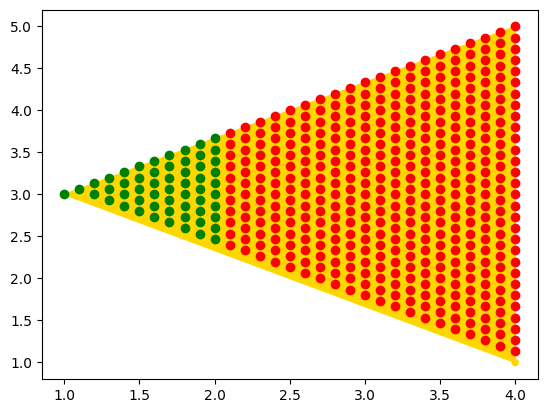

In [80]:
X = np.array([[1,3], [4,1], [4, 5]])
Y = ['gold', 'gold', 'gold']

plt.figure()
plt.scatter(X[:, 0], X[:, 1], s = 20, color = Y[:])

t1 = plt.Polygon(X[:3,:], color=Y[0])
plt.gca().add_patch(t1)

plt.plot(1, 3, 'go')

number_steps = 30

for i in range(number_steps):
    for j in range(number_steps-i):
        alpha = i/number_steps
        beta = j/number_steps
        P = alpha*PR + beta*P_0 + (1-alpha-beta)*P_1
        if h_flat(matrix_to_tensor(P))[0] > 0.91:
            plt.plot(X[0,0]*alpha + X[1,0]*beta + X[2,0]*(1-alpha-beta), X[0,1]*alpha + X[1,1]*beta + X[2,1]*(1-alpha-beta), 'go')
        else:
            plt.plot(X[0,0]*alpha + X[1,0]*beta + X[2,0]*(1-alpha-beta), X[0,1]*alpha + X[1,1]*beta + X[2,1]*(1-alpha-beta), 'ro')



plt.show()